In [57]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# nn models
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# sk-learn utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

# save and load models
from joblib import dump, load

## Dataset

### Load dataset

In [60]:
devices = pd.read_csv("dataset.csv", delimiter=" ")
devices.head()

,device,max_iat,max_rtt,mean_iat,mean_rtt,median_iat,median_rtt,min_iat,min_rtt
0,0,0.000014,0.183980,0.000006,0.008211,0.000003,0.004000,0.000002,0.002662
1,0,0.000014,0.112005,0.000009,0.006274,0.000013,0.004000,0.000003,0.003973
2,0,0.000019,0.123997,0.000011,0.006267,0.000013,0.003999,0.000002,0.003971
3,0,0.000014,0.124003,0.000010,0.006383,0.000013,0.003999,0.000003,0.003956
4,0,0.000019,0.119981,0.000011,0.006143,0.000013,0.003999,0.000002,0.003958


### Split dataset into data and labels

In [61]:
X = devices.iloc[:, 1:9]
y = devices.select_dtypes(include=[int])

### Make polynomial features

In [62]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(X.values[:,:])

### Split dataset into train and test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

y_train = y_train.values.ravel().astype(int)
y_test = y_test.values.ravel().astype(int)

### Scale data

In [64]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## ML models

### Utility functions

In [65]:
def plot_learning_curve(classifier, title, X, y, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title, fontsize=20, fontweight='bold')

    # X axis
    plt.xlabel("Training examples", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)

    # Y axis
    plt.ylabel("F1-Score", fontsize=16, fontweight='bold')
    plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=14)
    plt.ylim(0, 1.1)

    train_sizes, train_scores, test_scores = learning_curve(classifier, X, y, cv=StratifiedShuffleSplit(n_splits=10),
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best", fontsize=16)

    plt.grid()
    plt.savefig('figures/{}.png'.format(title))
    print("Learning curves for {} saved at {}.png".format(title, title))


def search_best_hyperparameters(classifiers, X_train, y_train):
    for _, params in classifiers.items():
        print("Starting grid search...")

        param_search = GridSearchCV(params['classifier'], params['grid_params'], cv=10, n_jobs=-1)
        param_search.fit(X_train, y_train)
        
        best_classifier = param_search.best_estimator_
        best_classifier.fit(X_train, y_train)
        params['classifier'] = best_classifier
        print("Grid search: ok")


def print_scores_on_test_set(classifier, title, X_test, y_test):
    y = classifier.predict(X_test)

    print("Classification report for %s classifier" % title)
    print(classification_report(y_test, y))

### Classifiers and their hyperparameters

In [68]:
classifiers = {
    'LogisticRegression': {
        'classifier': LogisticRegression(solver='lbfgs', multi_class="ovr", max_iter=10e6),
        'grid_params': {
            'C': np.arange(0.001, 10, 0.05)
        },
    },
    'MLP': {
        'classifier': MLPClassifier(max_iter=50000, solver = 'adam'),
        'grid_params': {
            'hidden_layer_sizes': [(15, 15), (10, 10, 10), (15, 15, 15)]
        }
    },
    'RandomForest': {
        'classifier': RandomForestClassifier(random_state=0),
        'grid_params': {
            'n_estimators': [5, 8, 10, 15, 25, 50, 100],
            'max_depth': [1, 2, 4, 8, 10, 12, 15, 18]
        }
    }
}

### Grid search with cross-validation to find best hyperparameters

In [69]:
search_best_hyperparameters(classifiers, X_train, y_train)

Starting grid search...
Grid search: ok
Starting grid search...
Grid search: ok
Starting grid search...
Grid search: ok


### Save best models

In [70]:
for classifier, params in classifiers.items():
    dump(params['classifier'], 'models/'+classifier+'.joblib')

### Print test scores

In [71]:
for classifier, params in classifiers.items():
    print_scores_on_test_set(params['classifier'], classifier, X_test, y_test)

Classification report for LogisticRegression classifier
              precision    recall  f1-score   support

           0       0.83      0.54      0.65        28
           1       1.00      1.00      1.00        15
           2       0.68      0.85      0.76        20
           3       0.79      0.75      0.77        20
           4       1.00      1.00      1.00        24
           5       0.78      0.84      0.81        25
           6       0.50      0.54      0.52        13
           7       0.79      0.83      0.81        18
           8       0.31      0.27      0.29        15
           9       0.92      0.88      0.90        26
          10       0.80      0.80      0.80        15
          11       0.75      0.71      0.73        17
          12       0.68      0.81      0.74        26
          13       0.89      0.94      0.92        18

    accuracy                           0.78       280
   macro avg       0.77      0.77      0.76       280
weighted avg       0.78 

### Plot learning curves

Warning: this may take several minutes

Learning curves for LogisticRegression saved at LogisticRegression.png
Learning curves for MLP saved at MLP.png
Learning curves for RandomForest saved at RandomForest.png


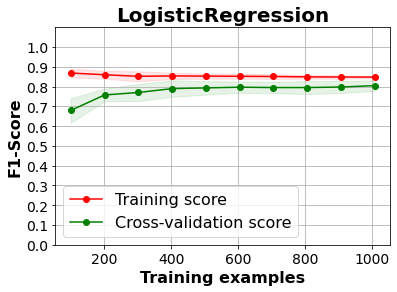

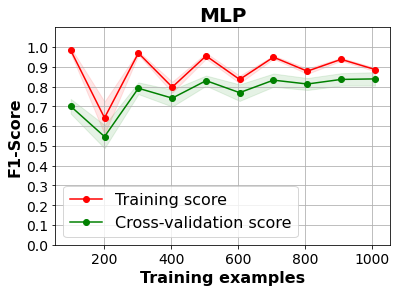

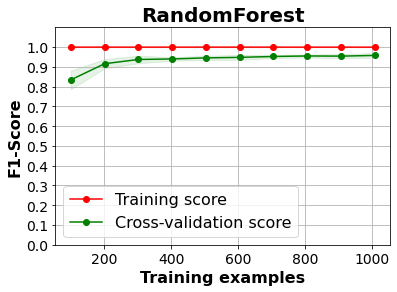

In [72]:
for classifier, params in classifiers.items():
    plot_learning_curve(params['classifier'], classifier, X_train, y_train)

### Confusion matrices

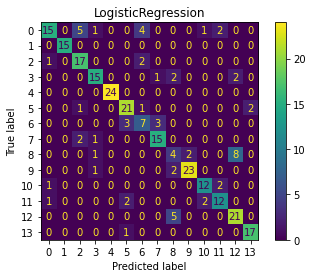

<Figure size 2160x2160 with 0 Axes>

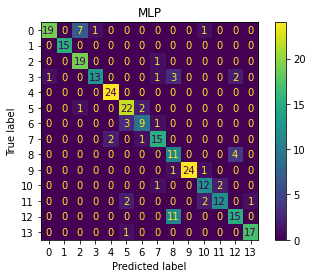

<Figure size 2160x2160 with 0 Axes>

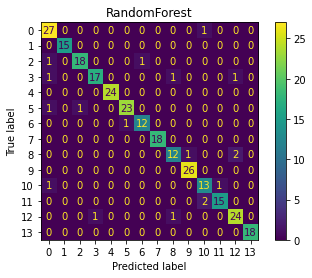

<Figure size 2160x2160 with 0 Axes>

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay

for classifier, params in classifiers.items():
    clf = params['classifier']
    y_pred = clf.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(classifier)
    plt.figure(figsize=(30,30))
    plt.show()
    

In [88]:
for classifier, params in classifiers.items():
    print(params['classifier'].get_params())

{'C': 9.801, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000000.0, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (15, 15, 15), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 50000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'mi